In [1]:
%matplotlib inline

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost.sklearn import XGBClassifier

import os
import sys
# sys.path.append(os.path.join(os.getcwd(), '..'))

In [3]:
seed = 12

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    fig, ax = plt.subplots(figsize=(20, 17))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylim(len(classes)-0.5, -0.5)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def load_data(embeddings_dir):
    y_file, X_file = os.path.join(embeddings_dir, 'metadata.tsv'), os.path.join(embeddings_dir, 'tensors.tsv')
    y = pd.read_csv(y_file, sep=':', encoding='utf-8', header=None).rename(columns={0:'job', 1:'name'})
    X = pd.read_csv(X_file, sep='\t', encoding='utf-8', header=None)
    return X, y

In [5]:
X, y = load_data('../projections/elmo_corpus_sentence/00000/default/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [6]:
y_train.head()

,job,name
597,muzycy,Christian Zacharias
441,poeci,Justyna Bargielska
216,prawnicy,Roman Jasiakiewicz
449,dziennikarze,Andrzej Poczobut
56,sportowcy,Stefan Żeromski


In [7]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
597,-0.048381,-0.355912,0.613536,-0.004878,0.010968,-0.115779,0.419093,-0.644496,-0.550788,0.189552,...,-0.499104,0.473381,-0.360022,0.042702,0.074446,-0.594111,-0.231287,1.218542,-0.241716,-0.549961
441,0.311885,-0.016739,0.028832,-0.047952,-0.203623,0.556829,0.644996,-1.070214,-0.236442,0.409834,...,-0.492679,0.688189,-0.253620,-0.048724,-0.427597,-1.086891,-0.027440,1.173607,-0.026086,-0.817411
216,0.090499,-0.146783,0.185936,-0.143243,-0.019126,0.174426,0.731200,-0.314080,-0.451317,0.541313,...,-0.912254,0.894044,-0.279921,0.121955,-0.062777,-0.294018,0.611186,0.946440,-0.556574,-0.670000
449,0.199854,-0.041391,0.289144,-0.138243,-0.022552,0.435773,0.611636,-0.514663,-0.218814,0.406373,...,-0.651733,0.699543,-0.461065,-0.055890,0.074341,-0.475765,0.169236,0.835361,-0.579574,-0.622776
56,0.014216,-0.123449,0.390100,0.177011,-0.258306,0.236781,0.535896,-0.211681,-0.048557,0.367458,...,-0.427437,0.710641,-0.486745,0.271303,0.129309,-0.398488,0.087874,0.914504,-0.537695,-0.452681


In [8]:
names_train, names_test = y_train['name'], y_test['name']
y_train, y_test = y_train['job'], y_test['job']

In [35]:
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=seed)
# model = XGBClassifier(learning_rate=0.01, n_estimators=300, n_jobs=-1, random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [36]:
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {round(accuracy*100, 2)}%')

Accuracy: 49.23%


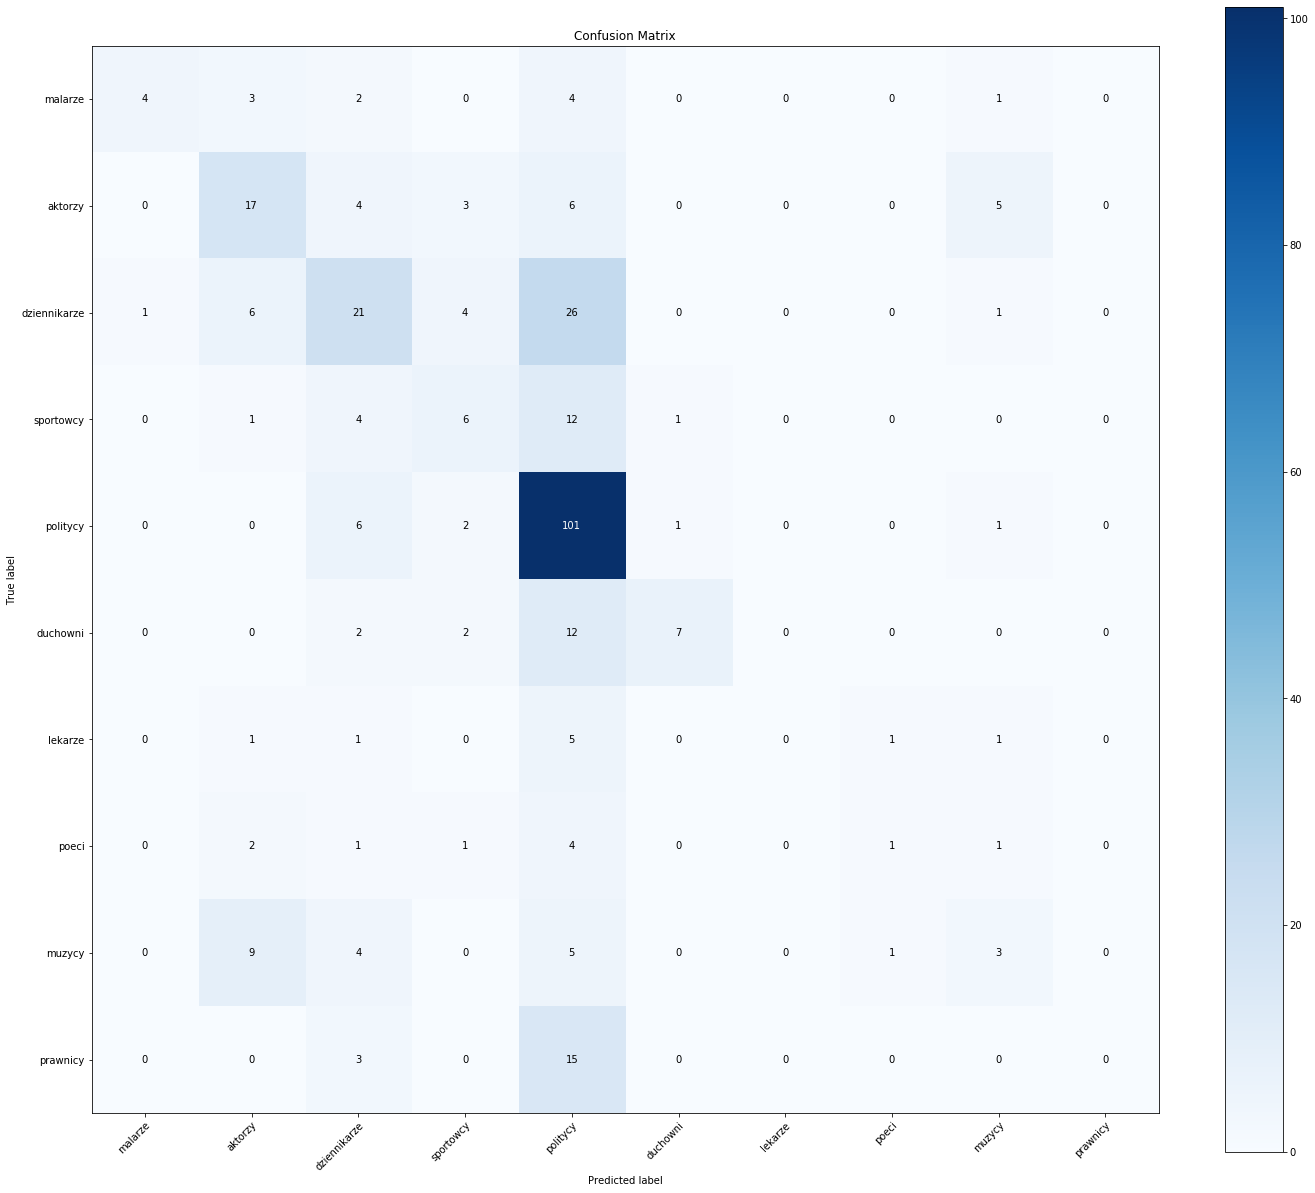

In [37]:
classes = y_test.unique()
plot_confusion_matrix(y_test, preds, classes, 'Confusion Matrix')